In [1]:

import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

folder_figures ='figures'

In [2]:
# Load reg_df as the df_to_plot
reg_perf_dir = "data/performances_exp_blosum_640_mae_no_mean" # change accordingly
reg_df = pd.DataFrame({})
rank_by = 'spearman'

train_metric_values, train_metric_std, test_metric_values, test_metric_std = [],[],[],[]
regressors, embeddings, strat_methods = [],[],[]
for filename in os.listdir(reg_perf_dir):
    if filename.endswith("_perf.csv"):
        csv_path = os.path.join(reg_perf_dir, filename)
        perf_df = pd.read_csv(csv_path)

        reg_name = filename.replace('_perf.csv','')
        list_embed = perf_df['embeddings'].to_list()
        list_strat_method = perf_df['strat_method'].to_list()
            
        regressors.extend([reg_name]*len(perf_df.index))
        embeddings.extend(list_embed)
        strat_methods.extend(list_strat_method)
                
        train_metric_values.extend(perf_df[f'mean_{rank_by}_train'].to_list())
        train_metric_std.extend(perf_df[f'std_{rank_by}_train'].to_list())
        test_metric_values.extend(perf_df[f'mean_{rank_by}_test'].to_list())
        test_metric_std.extend(perf_df[f'std_{rank_by}_test'].to_list())

reg_df['reg'] = regressors
reg_df['embeddings'] = embeddings
reg_df['strat_method'] = strat_methods

reg_df[f'mean_{rank_by}_train'] = train_metric_values
reg_df[f'std_{rank_by}_train'] = train_metric_std
reg_df[f'mean_{rank_by}_test'] = test_metric_values
reg_df[f'std_{rank_by}_test'] = test_metric_std

train_upper_bound = [reg_df[f'mean_{rank_by}_train'][i]+reg_df[f'std_{rank_by}_train'][i] for i in range(len(reg_df))]
train_lower_bound = [reg_df[f'mean_{rank_by}_train'][i]-reg_df[f'std_{rank_by}_train'][i] for i in range(len(reg_df))]
reg_df[f'train_{rank_by}_upper_bound'] = train_upper_bound
reg_df[f'train_{rank_by}_lower_bound'] = train_lower_bound

test_upper_bound = [reg_df[f'mean_{rank_by}_test'][i]+reg_df[f'std_{rank_by}_test'][i] for i in range(len(reg_df))]
test_lower_bound = [reg_df[f'mean_{rank_by}_test'][i]-reg_df[f'std_{rank_by}_test'][i] for i in range(len(reg_df))]
reg_df[f'test_{rank_by}_upper_bound'] = test_upper_bound
reg_df[f'test_{rank_by}_lower_bound'] = test_lower_bound

        
# Some renaming
# this was for my previous raw data (typo, cap, etc); change accordingly
mapping_dict = {'onehot': 'One-hot', 
                'esm_msa1b': 'esm_msa1b', 
                'esm1b': 'ESM-1b',
                'esm2_t6': 'esm2_t6',
                'esm2_t12': 'esm2_t12',
                'esm2_t30': 'ESM-2',
                'esm2_t33': 'esm2_t33',
                'esm2_t36': 'esm2_t36',
                'antiberty': 'AntiBERTy',
                'ablang': 'AbLang',
                'nanobert': 'nanoBERT',
                'nanobuilder': 'NanoBodyBuilder',
                'vhse': 'VHSE'
                } 
reg_df['embeddings'] = reg_df['embeddings'].map(mapping_dict)

reg_df['strat_method'] = reg_df['strat_method'].replace('none', 'Random split')
reg_df['strat_method'] = reg_df['strat_method'].replace('exp_method', 'Experiment method')
reg_df['strat_method'] = reg_df['strat_method'].replace('clust_kmeans_esm1b', 'KMeans-ESM1b cluster')
reg_df['strat_method'] = reg_df['strat_method'].replace('expmeth_kmeans_esm1b', 'Experiment and KMeans-ESM1b')
reg_df['strat_method'] = reg_df['strat_method'].replace('clust_kmedoids_blosum', 'KMedoids-BLOSUM cluster')
reg_df['strat_method'] = reg_df['strat_method'].replace('expmeth_clust_kmedoids_blosum', 'Experiment and KMedoids-BLOSUM')
reg_df['strat_method'] = reg_df['strat_method'].replace('loco', 'LOCO-KMedoids-BLOSUM')
reg_df = reg_df.replace('ridge','Ridge')
reg_df = reg_df.replace('huber','Huber')
reg_df = reg_df.replace('elasticnet','ElasticNet')

print(reg_df.shape)
print(reg_df.columns)


(64, 11)
Index(['reg', 'embeddings', 'strat_method', 'mean_spearman_train',
       'std_spearman_train', 'mean_spearman_test', 'std_spearman_test',
       'train_spearman_upper_bound', 'train_spearman_lower_bound',
       'test_spearman_upper_bound', 'test_spearman_lower_bound'],
      dtype='object')


In [3]:
# Define strat_methods, regressions, and embeddings for plotting
regressions = [
                'Ridge',
                ]

strat_methods = ['Random split','Experiment and KMedoids-BLOSUM', 
				#'KMeans-ESM1b cluster','Experiment and KMeans-ESM1b',
              #  'KMedoids-BLOSUM cluster', 'Experiment and KMedoids-BLOSUM',
                # 'LOCO-KMedoids-BLOSUM'
]


embeddings = [
        'One-hot',
        'VHSE',
        'ESM-1b',
       # 'esm2_t12',
        'ESM-2',
        #'esm2_t33',
        'AntiBERTy',
        'AbLang',
        'nanoBERT',
        'NanoBodyBuilder'
            ]

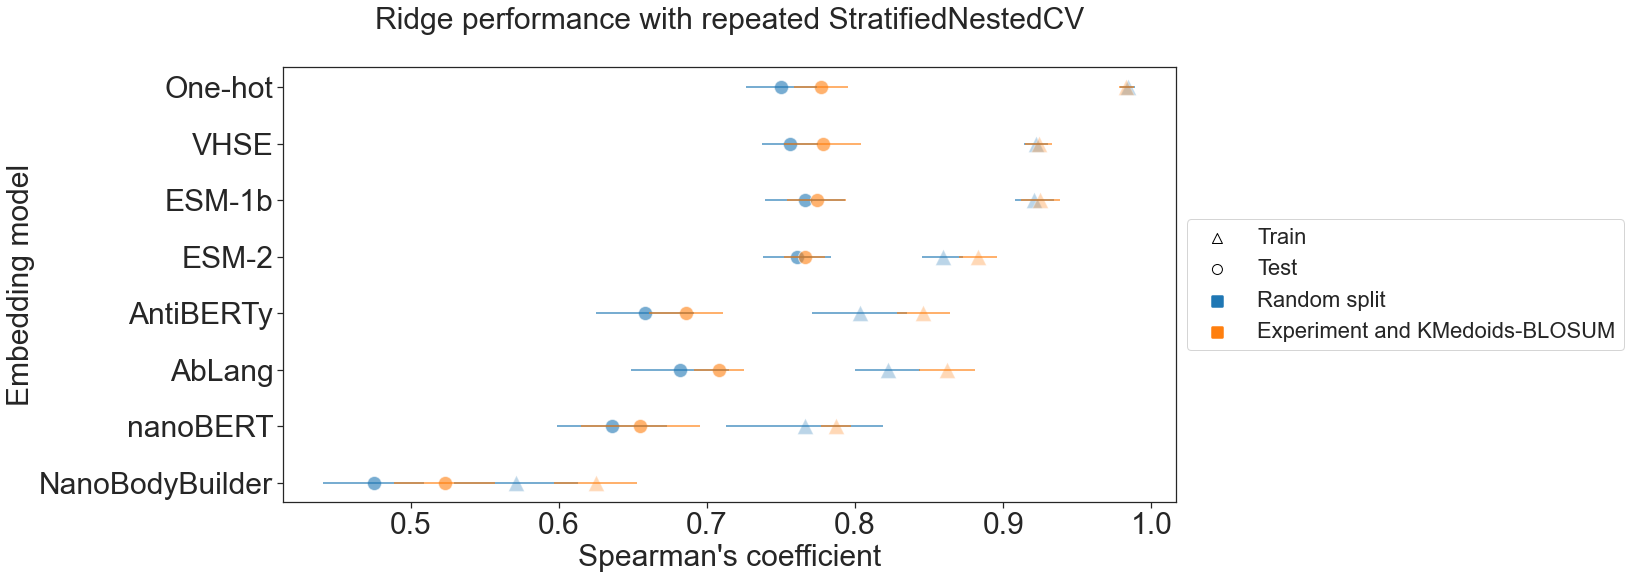

In [4]:
# Plot comparison between different stratification methods for each regression
metric = 'spearman'

for k in range(len(regressions)): 
    reg = regressions[k]
    indiv_reg_df = reg_df[reg_df['reg']==reg].reset_index(drop=True).copy()
    indiv_reg_df['embeddings'] = pd.Categorical(indiv_reg_df['embeddings'], categories=embeddings, ordered=True)
    indiv_reg_df = indiv_reg_df.sort_values('embeddings').dropna(subset='embeddings')
    indiv_reg_df = indiv_reg_df[indiv_reg_df['embeddings'].isin(embeddings)]

    sns.set_theme(style='white')
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.grid(False)
    cmap = plt.get_cmap('tab10')
    colors = cmap.colors
    
    # Legend (train and test)
    ax.scatter(y=[],x=[],edgecolor='black',facecolor='none',marker='^',label='Train',s=100)
    ax.scatter(y=[],x=[],edgecolor='black',facecolor='none',marker='o',label='Test',s=100)

    # Plot performance of each stratification method
    for i in range(len(strat_methods)):
        strat = strat_methods[i]
        class_df = indiv_reg_df[indiv_reg_df['strat_method']==strat].reset_index(drop=True).copy()
        # Plot data
        mean_train=sns.scatterplot(y=class_df['embeddings'], x=class_df[f'mean_{metric}_train'], 
                        color=colors[i], marker='^', legend=False, s=250, alpha=0.3)
        mean_test=sns.scatterplot(y=class_df['embeddings'], x=class_df[f'mean_{metric}_test'],
                        color=colors[i], marker='o', legend=False, s=200, alpha=0.6)
        # Plot error bars
        for j in range(len(class_df)):
            ax.errorbar(y=class_df['embeddings'][j], x=class_df[f'mean_{metric}_train'][j], xerr=class_df[f'std_{metric}_train'][j], fmt='none', alpha=0.8, color=colors[i])
        for j in range(len(class_df)):
            ax.errorbar(y=class_df['embeddings'][j], x=class_df[f'mean_{metric}_test'][j], xerr=class_df[f'std_{metric}_test'][j], fmt='none', alpha=0.8, color=colors[i])
        # Legend (strat methods)
        ax.scatter(y=[],x=[],color=colors[i],label=f'{strat}',linewidth=2.5,marker='s',s=100)
    
    plt.title(f'{reg} performance with repeated StratifiedNestedCV\n',fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel('Embedding model',fontsize=30)
    plt.xlabel(f"{metric.capitalize()}'s coefficient",fontsize=30)
    plt.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5),fontsize=22)
    plt.tick_params(bottom=True, left=True, labelsize=30)
    plt.savefig(os.path.join(folder_figures, f'figureS8.png'), dpi=800, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()


In [5]:
# Load reg_df as the df_to_plot
reg_df = pd.DataFrame({})
rank_by = 'spearman'

train_metric_values, train_metric_std, test_metric_values, test_metric_std = [],[],[],[]
regressors, embeddings, strat_methods = [],[],[]
for filename in os.listdir(reg_perf_dir):
    if filename.endswith("_perf.csv"):
        csv_path = os.path.join(reg_perf_dir, filename)
        perf_df = pd.read_csv(csv_path)

        reg_name = filename.replace('_perf.csv','')
        list_embed = perf_df['embeddings'].to_list()
        list_strat_method = perf_df['strat_method'].to_list()
            
        regressors.extend([reg_name]*len(perf_df.index))
        embeddings.extend(list_embed)
        strat_methods.extend(list_strat_method)
                
        train_metric_values.extend(perf_df[f'mean_{rank_by}_train'].to_list())
        train_metric_std.extend(perf_df[f'std_{rank_by}_train'].to_list())
        test_metric_values.extend(perf_df[f'mean_{rank_by}_test'].to_list())
        test_metric_std.extend(perf_df[f'std_{rank_by}_test'].to_list())

reg_df['reg'] = regressors
reg_df['embeddings'] = embeddings
reg_df['strat_method'] = strat_methods

reg_df[f'mean_{rank_by}_train'] = train_metric_values
reg_df[f'std_{rank_by}_train'] = train_metric_std
reg_df[f'mean_{rank_by}_test'] = test_metric_values
reg_df[f'std_{rank_by}_test'] = test_metric_std

train_upper_bound = [reg_df[f'mean_{rank_by}_train'][i]+reg_df[f'std_{rank_by}_train'][i] for i in range(len(reg_df))]
train_lower_bound = [reg_df[f'mean_{rank_by}_train'][i]-reg_df[f'std_{rank_by}_train'][i] for i in range(len(reg_df))]
reg_df[f'train_{rank_by}_upper_bound'] = train_upper_bound
reg_df[f'train_{rank_by}_lower_bound'] = train_lower_bound

test_upper_bound = [reg_df[f'mean_{rank_by}_test'][i]+reg_df[f'std_{rank_by}_test'][i] for i in range(len(reg_df))]
test_lower_bound = [reg_df[f'mean_{rank_by}_test'][i]-reg_df[f'std_{rank_by}_test'][i] for i in range(len(reg_df))]
reg_df[f'test_{rank_by}_upper_bound'] = test_upper_bound
reg_df[f'test_{rank_by}_lower_bound'] = test_lower_bound

        
# Some renaming
# this was for my previous raw data (typo, cap, etc); change accordingly
mapping_dict = {'onehot': 'One-hot', 
                'esm_msa1b': 'esm_msa1b', 
                'esm1b': 'ESM-1b',
                'esm2_t30': 'ESM-2',
                'antiberty': 'AntiBERTy',
                'ablang': 'AbLang',
                'nanobert': 'nanoBERT',
                'nanobuilder': 'NanoBodyBuilder',
                'vhse': 'VHSE'
                } 
reg_df['embeddings'] = reg_df['embeddings'].map(mapping_dict)

reg_df['strat_method'] = reg_df['strat_method'].replace('none', 'Random split')
reg_df['strat_method'] = reg_df['strat_method'].replace('exp_method', 'Experiment method')
reg_df['strat_method'] = reg_df['strat_method'].replace('clust_kmeans_esm1b', 'KMeans-ESM1b cluster')
reg_df['strat_method'] = reg_df['strat_method'].replace('expmeth_kmeans_esm1b', 'Experiment and KMeans-ESM1b')
reg_df['strat_method'] = reg_df['strat_method'].replace('clust_kmedoids_blosum', 'KMedoids-BLOSUM cluster')
reg_df['strat_method'] = reg_df['strat_method'].replace('expmeth_clust_kmedoids_blosum', 'Experiment and KMedoids-BLOSUM')
reg_df['strat_method'] = reg_df['strat_method'].replace('looc', 'LOCO-KMedoids-BLOSUM')
reg_df = reg_df.replace('ridge','Ridge')
reg_df = reg_df.replace('huber','Huber')
reg_df = reg_df.replace('elasticnet','ElasticNet')

print(reg_df.shape)
print(reg_df.columns)


(64, 11)
Index(['reg', 'embeddings', 'strat_method', 'mean_spearman_train',
       'std_spearman_train', 'mean_spearman_test', 'std_spearman_test',
       'train_spearman_upper_bound', 'train_spearman_lower_bound',
       'test_spearman_upper_bound', 'test_spearman_lower_bound'],
      dtype='object')


In [6]:
# Define strat_methods, regressions, and embeddings for plotting
regressions = [
                'Ridge',
                'Huber',
                'ElasticNet',
                'RF',
                'LightGBM',
                'SVR',
                'GPR'
                ]

strat_methods = ['Random split','Experiment method', 
				'KMeans-ESM1b cluster','Experiment and KMeans-ESM1b',
                'KMedoids-BLOSUM cluster', 'Experiment and KMedoids-BLOSUM',
                #'LOCO-KMedoids-BLOSUM'
]

metric = 'spearman'

embeddings = [
        'One-hot',
        'VHSE',
        'ESM-1b',
        'ESM-2',
        'AntiBERTy',
        'AbLang',
        'nanoBERT',
        'NanoBodyBuilder'
            ]

<ipython-input-16-aaa2035b11b4>:33: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(mpatches.Patch(color=colors[i], label=f'{reg}', alpha=1, edgecolor='black'))


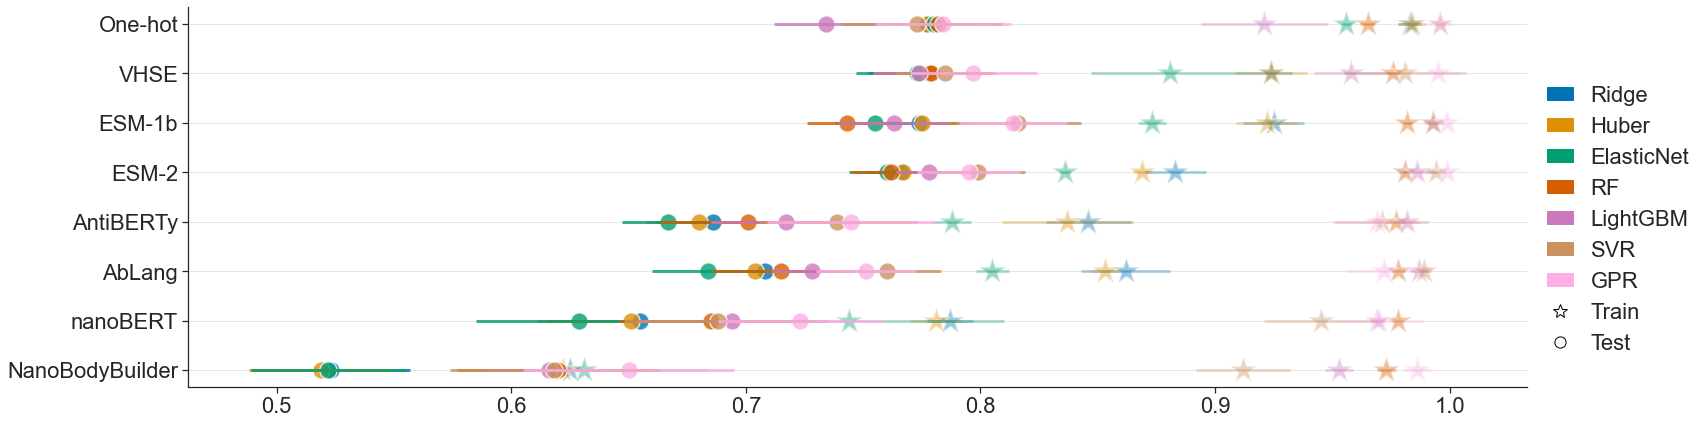

In [16]:
# Plot comparison between regressions for stratifying with expmeth_kmeans_esm1b
def plot_allreg_strat(reg_df, strat_method = 'expmeth_clust_kmedoids_blosum'):

  sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                          'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
  fig, ax = plt.subplots(figsize=(24,7))
  

  colors = sns.color_palette("colorblind")

  df_strat = reg_df[reg_df['strat_method']==strat_method]

  for i in range(len(regressions)):
      reg = regressions[i]
      indiv_reg_df = df_strat[df_strat['reg'] == reg].reset_index()
      indiv_reg_df['embeddings'] = pd.Categorical(indiv_reg_df['embeddings'], categories=embeddings, ordered=True)
      indiv_reg_df = indiv_reg_df.sort_values('embeddings').dropna(subset='embeddings').reset_index()
      # Plot data
      mean_train=sns.scatterplot(y=indiv_reg_df['embeddings'], x=indiv_reg_df[f'mean_{metric}_train'], color=colors[i], marker='*', s=750, alpha=0.4)
      mean_test=sns.scatterplot(y=indiv_reg_df['embeddings'], x=indiv_reg_df[f'mean_{metric}_test'], color=colors[i], marker='o',s=300,alpha=0.8)
      # Plot error bars
      for j in range(len(indiv_reg_df)):
        ax.errorbar(y=indiv_reg_df['embeddings'][j], x=indiv_reg_df[f'mean_{metric}_train'][j], xerr=indiv_reg_df[f'std_{metric}_train'][j], fmt='none', linewidth=3,alpha=0.3, color=colors[i])
      for j in range(len(indiv_reg_df)):
        ax.errorbar(y=indiv_reg_df['embeddings'][j], x=indiv_reg_df[f'mean_{metric}_test'][j], xerr=indiv_reg_df[f'std_{metric}_test'][j], fmt='none', linewidth=3,alpha=0.8, color=colors[i])
  
  ax.yaxis.grid(True, color='black', linestyle='-', alpha=0.1)

  handles = list()

  for i in range(len(regressions)):
    reg = regressions[i]
    handles.append(mpatches.Patch(color=colors[i], label=f'{reg}', alpha=1, edgecolor='black'))

  handles.extend([Line2D([0], [0], marker='*', color='w', markeredgecolor='black', markerfacecolor='white', markersize=9, label='Train'),
              Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markerfacecolor='white', markersize=7, label='Test')])

  legend = ax.legend(handles=handles, title=' \n \n ',
                      loc='center left', ncol=1, bbox_to_anchor=(1, 0.5),frameon=True, markerscale=1.6, fontsize=22, edgecolor = 'w', handlelength=1.2, handleheight=0.55)

  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  plt.ylabel('',fontsize=30)
  plt.xlabel('',fontsize=30)
  #plt.title(f'Regression Performance with Repeated StratifiedNestedCV ({strat_method})\n',fontsize=30,pad=10)
  plt.tick_params(bottom=True, left=True, labelsize=22)
  plt.savefig(os.path.join(folder_figures, f'figure4a.png'), dpi=800, bbox_inches='tight', transparent=True)
  plt.show()
  plt.close()

plot_allreg_strat(reg_df=reg_df, strat_method = 'Experiment and KMedoids-BLOSUM') #Experiment and KMedoids-BLOSUM